In [1]:
import numpy as np
from skimage.io import imread
from tqdm import tqdm
import glob, os, dxchange
import matplotlib.pyplot as plt
import pandas as pd


olefile module not found


In [1]:
# select IPTS

In [ ]:
# Select top folder of data to reconstruct
## program will load and automatically make a list of good runs and bad runs  

In [4]:
# combine all the images within each run

In [11]:
# parameters used for data cleaning
"""
if_clean: switch of cleaning operation (bool)
if_save_clean: switch of saving cleaned tiff files (bool)
low_gate: the lower index of the image hist bin edges (int 0-9)
high_gate: the higher index of the image hist bin edges (int 0-9)
correct_radius: the neighbors (2r+1 * 2r+1 matrix) radius used for replacing bad pixels (int) 
"""
clean_paras = {'if_clean': True, 'if_save_clean': False, 'low_gate': 1, 'high_gate': 9, 'correct_radius': 1}

In [12]:
# pre-processing
"""
DataCleaner Class: find the abnormal pixels (extremely low/high) and replaced by median value of the neighor matrix
===========
to initiate cleaner: 
data_cleaner = DataCleaner(clean_paras, clean_path)
[clean_paras]: parameters used for cleaning (dictionary)
[clean_path]: the directory where save the cleaned data (if save) and logs (strings)
===========
to clean a 2D image:
cleaned_data = data_cleaner(orginal_im, save_file_name)
[original_im]: the image need to be cleaned (M*M array)
[save_file_name]: the cleaned tiff and its log will be saved in this name (strings)

"""

class DataCleaner(object): 
    def __init__(self, paras, clean_path):
        # for clean data
        self.low_gate = paras['low_gate']
        self.high_gate = paras['high_gate']
        self.r = paras['correct_radius']
        self.CLEAN = paras['if_clean']
        self.SAVE_CLEAN = paras['if_save_clean']
        self.clean_path = clean_path
        
    def run(self, im, fname):
        self.im = im
        self.row, self.col = self.im.shape
        self.corr_im = np.nan_to_num(self.im.copy(), nan=0, posinf=0, neginf=0)
        self.log = {}
        self.fname = fname

        if self.CLEAN:
            self.replace_pix()
            self.save_opt()

    def replace_pix(self):
        hist, bin_edges = np.histogram(self.corr_im.flatten(), density=False)
        thres_low = bin_edges[self.low_gate]
        thres_high = bin_edges[self.high_gate]
        x_coords, y_coords = np.nonzero(np.logical_or(self.corr_im <= thres_low, self.corr_im > thres_high))
        r = self.r

        org_val, cor_val = [], []
        for x, y in zip(x_coords, y_coords):
            X_, _X = max(0, x-r), min(self.corr_im.shape[0], x+r)
            Y_, _Y = max(0, y-r), min(self.corr_im.shape[1], y+r)
            org_val.append(self.corr_im[x, y])
            pat = self.im[X_ : _X+1, Y_: _Y+1]
            if np.nonzero(pat > thres_low)[0].size >=4:
                _elements = list(pat.flatten())
                _elements.pop(r*(1+2*r)+r)
                _corrected = np.median(_elements)#sum(_elements)/(pat.size-1)
                self.corr_im[x, y] = _corrected
                cor_val.append(_corrected)
            else:
                print('ERROR, too many zeros around pixel({},{})'.format(x, y))
                cor_val.append('-')
        
        self.log = {'fname': self.fname, 'X': x_coords, 'Y': y_coords, 
                    'original': org_val, 'corrected': cor_val}
        
    def save_opt(self):
        if self.SAVE_CLEAN:
            _fname = os.path.join(self.clean_path, f'ZeroRemove_{self.fname}')
            dxchange.writer.write_tiff(self.corr_im, fname=_fname, overwrite=True)

        log_fld = os.path.join(self.clean_path, 'logs')
        df = pd.DataFrame.from_dict(self.log, orient='columns')
        df.to_csv(os.path.join(log_fld, f'clean_log_{self.fname}.csv'))
        print(f'save log into {os.path.join(log_fld, f'clean_log_{self.fname}.csv')}')


In [ ]:
# load a data
fld_path = ('/SNS/VENUS/IPTS-33699/shared/processed_data/'
            'September20_2024_PurpleCar_GoldenRatio_CT_5_0_C_Cd_inBeam_Resonance/Run_3047')
fls_lst = glob.glob(os.path.join(fld_path, '*.tif*'))
fls_lst.sort()

data = []

for fl in tqdm(fls_lst):
    data.append((imread(fl).astype(np.float32)).swapaxes(0,1))
hype_data = np.array(data)

In [ ]:
# sum all bands
sum_im = hype_data.sum(axis=0)[10:-10, 10:-10]

In [ ]:
# display histogram
plt.hist(sum_im.flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.yscale('log')

In [ ]:
# check the details of histogram
hist, bin_edges = np.histogram(sum_im.flatten(), density=False)
bin_edges[9]

In [ ]:
# initialize cleaner
data_cleaner = DataCleaner(clean_paras, clean_path='/home/gxt/Projects')

In [17]:
# clean the data
data_cleaner.run(sum_im, 'Run_3047')
clean_data = data_cleaner.corr_im
clean_log = data_cleaner.log

/home/gxt/Projects/logs/clean_log_Run_3047.csv


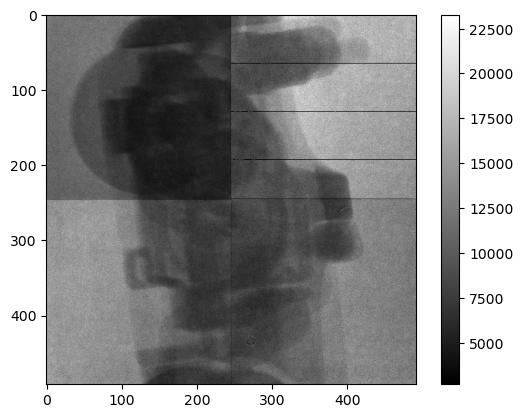

In [19]:
plt.imshow(clean_data, cmap='gray')
plt.colorbar()

In [7]:
# normalization

In [8]:
# chips correction

In [9]:
# calculate center of rotation

In [10]:
# calculate tilt correction and apply it

In [ ]:
# launch svmbir